In [123]:
import sys
from os.path import expanduser
sys.path.append(expanduser("~/robosat.pink/"))

from robosat_pink.datasets import *
from robosat_pink.tiles import *

from sklearn.model_selection import train_test_split

from robosat_pink.models import albunet
from robosat_pink.tools.train import train, validate
from robosat_pink.losses.lovasz import Lovasz
import robosat_pink

import albumentations as A

from skimage import exposure

from numpy.random import choice
from math import floor

from tqdm import tqdm

from datetime import datetime

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

from os import environ
environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'
environ['AWS_DEFAULT_PROFILE'] = 'esip'

from imp import reload
reload(robosat_pink.losses.lovasz)
reload(robosat_pink.tools.train)
from robosat_pink.tools.train import train, validate
from robosat_pink.losses.lovasz import Lovasz

from io import BytesIO

CHECKPOINT = "s3://planet-snowcover-models/checkpoint-190319-20:47:57"
S3_CHECKPOINT = False
if CHECKPOINT.startswith("s3://"):
    S3_CHECKPOINT = True
    # load from s3 
    CHECKPOINT = CHECKPOINT[5:]
    sess = boto3.Session(profile_name=environ['AWS_DEFAULT_PROFILE'])
    fs = s3fs.S3FileSystem(session=sess)
    s3ckpt = s3fs.S3File(fs, CHECKPOINT, 'rb')

import matplotlib.pyplot as plt
%matplotlib inline

# Test Training

In [7]:
# DATA_DIR = "s3://planet-snowcover-imagery/20180601_181450_0f32_3B_AnalyticMS_SR_clip_tiled"
DATA_DIR = "s3://planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_SR_clip_tiled"
MASK_DIR = "s3://planet-snowcover-snow/ASO_3M_SD_USCASJ_20180601_tiles_02"
all_tiles = SlippyMapTilesConcatenation(path = DATA_DIR, 
                                        target = MASK_DIR, 
                                        aws_profile = 'esip')

In [8]:
train_ids, test_ids = train_test_split(all_tiles.tiles)

In [9]:
# # train_ids_idx = choice(range(0, len(train_ids)), floor(len(train_ids)))
# test_ids_idx = choice(range(0, len(test_ids)), floor(len(test_ids)))
# train_ids = [train_ids[i] for i in train_ids_idx]
# test_ids =  [test_ids[i] for i in test_ids_idx]

In [10]:
transform = A.Compose([
    #A.ToFloat(p = 1),
    # A.RandomRotate90(p = 0.5),
    #A.RandomRotate90(p = 0.5),
    #A.RandomRotate90(p = 0.5), #these do something bad to the bands
#    A.Normalize(mean = mean, std = std, max_pixel_value = 1),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
#    A.ToFloat(p = 1, max_value = np.finfo(np.float64).max)
])

train_tiles = SlippyMapTilesConcatenation(path = DATA_DIR, 
                                          target = MASK_DIR, 
                                          tiles = train_ids,
                                          aws_profile = 'esip',
                                          joint_transform = transform)
valid_tiles = SlippyMapTilesConcatenation(path = DATA_DIR, 
                                          target = MASK_DIR, 
                                          tiles = test_ids, 
                                          aws_profile = 'esip', 
                                          joint_transform = transform)

214
72


---
Some Neural Network Infrastrcuture

In [4]:
net = albunet.Albunet(num_classes = 1, num_channels = 4)
device = torch.device('cuda')
net = torch.nn.DataParallel(net)

criterion = Lovasz().to(device)
optimizer = Adam(net.parameters(), lr=0.001)

if CHECKPOINT is not None:
    def map_location(storage, _):
        return storage.cuda() if torch.cuda.is_available() else storage.cpu()
    try: 
        if S3_CHECKPOINT:
            with s3fs.S3File(fs, CHECKPOINT, 'rb') as C:
                state = torch.load(io.BytesIO(C.read()))
        else: 
            state = torch.load(io.BytesIO(C.read()))
        optimizer.load_state_dict(state['optimizer'])
        net.load_state_dict(state['state_dict'])
        net.to(device)
    except FileNotFoundError as f:
        print("{} checkpoint not found.".format(CHECKPOINT))

In [11]:
train_loader = DataLoader(train_tiles,
                          batch_size = 8,
                          shuffle  = True,
                          drop_last=True, 
                          num_workers = 0)

In [12]:
valid_loader = DataLoader(valid_tiles,
                          batch_size = 8,
                          shuffle  = True,
                          drop_last=True, 
                          num_workers = 0)

In [ ]:
for epoch in range(10):
    print("epoch {}".format(epoch))
    train_hist = train(train_loader, 1, device, net, optimizer, criterion)
    print(train_hist)

Train:   0%|          | 0/26 [00:00<?, ?batch/s]

epoch 0
torch.Size([8, 1, 512, 512]) torch.float32


Train:   4%|3         | 1/26 [00:08<03:24,  8.16s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:   8%|7         | 2/26 [00:15<03:02,  7.62s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  12%|#1        | 3/26 [00:22<02:50,  7.40s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  15%|#5        | 4/26 [00:29<02:41,  7.33s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  19%|#9        | 5/26 [00:36<02:33,  7.32s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  23%|##3       | 6/26 [00:43<02:26,  7.32s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  27%|##6       | 7/26 [00:50<02:17,  7.26s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  31%|###       | 8/26 [00:57<02:09,  7.18s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  35%|###4      | 9/26 [01:04<02:01,  7.14s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  38%|###8      | 10/26 [01:11<01:53,  7.11s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  42%|####2     | 11/26 [01:24<01:55,  7.68s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  46%|####6     | 12/26 [01:49<02:07,  9.11s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  50%|#####     | 13/26 [02:04<02:04,  9.59s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  54%|#####3    | 14/26 [02:11<01:52,  9.38s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  58%|#####7    | 15/26 [02:18<01:41,  9.21s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  62%|######1   | 16/26 [02:25<01:30,  9.09s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  65%|######5   | 17/26 [02:32<01:20,  8.96s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  69%|######9   | 18/26 [02:39<01:10,  8.87s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  73%|#######3  | 19/26 [02:46<01:01,  8.77s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  77%|#######6  | 20/26 [02:53<00:52,  8.70s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  81%|########  | 21/26 [03:00<00:43,  8.61s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  85%|########4 | 22/26 [03:09<00:34,  8.60s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  88%|########8 | 23/26 [03:16<00:25,  8.53s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  92%|#########2| 24/26 [03:23<00:16,  8.47s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  96%|#########6| 25/26 [03:29<00:08,  8.39s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:   0%|          | 0/26 [00:00<?, ?batch/s]

{'loss': 0.09873150948148507, 'miou': 0.3985613217720619, 'fg_iou': 0.0, 'mcc': nan}
epoch 1
torch.Size([8, 1, 512, 512]) torch.float32


Train:   4%|3         | 1/26 [00:06<02:31,  6.06s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:   8%|7         | 2/26 [00:12<02:24,  6.03s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  12%|#1        | 3/26 [00:17<02:17,  5.97s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  15%|#5        | 4/26 [00:23<02:10,  5.94s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  19%|#9        | 5/26 [00:29<02:05,  5.97s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  23%|##3       | 6/26 [00:37<02:04,  6.22s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  27%|##6       | 7/26 [00:45<02:03,  6.49s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  31%|###       | 8/26 [00:51<01:56,  6.46s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  35%|###4      | 9/26 [00:57<01:48,  6.40s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  38%|###8      | 10/26 [01:03<01:42,  6.38s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  42%|####2     | 11/26 [01:09<01:35,  6.35s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  46%|####6     | 12/26 [01:15<01:28,  6.32s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  50%|#####     | 13/26 [01:21<01:21,  6.29s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  54%|#####3    | 14/26 [01:27<01:15,  6.27s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  58%|#####7    | 15/26 [01:34<01:09,  6.28s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  62%|######1   | 16/26 [01:40<01:02,  6.28s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  65%|######5   | 17/26 [01:46<00:56,  6.27s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  69%|######9   | 18/26 [01:52<00:49,  6.25s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  73%|#######3  | 19/26 [01:58<00:43,  6.25s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  77%|#######6  | 20/26 [02:04<00:37,  6.25s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  81%|########  | 21/26 [02:11<00:31,  6.24s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  85%|########4 | 22/26 [02:17<00:24,  6.23s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  88%|########8 | 23/26 [02:23<00:18,  6.22s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  92%|#########2| 24/26 [02:29<00:12,  6.21s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  96%|#########6| 25/26 [02:34<00:06,  6.19s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:   0%|          | 0/26 [00:00<?, ?batch/s]

{'loss': 0.0941881061746524, 'miou': 0.3991260803662814, 'fg_iou': 0.0, 'mcc': nan}
epoch 2
torch.Size([8, 1, 512, 512]) torch.float32


Train:   4%|3         | 1/26 [00:05<02:23,  5.76s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:   8%|7         | 2/26 [00:11<02:18,  5.77s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  12%|#1        | 3/26 [00:17<02:11,  5.70s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  15%|#5        | 4/26 [00:22<02:05,  5.72s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  19%|#9        | 5/26 [00:28<02:00,  5.75s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  23%|##3       | 6/26 [00:34<01:54,  5.75s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  27%|##6       | 7/26 [00:40<01:49,  5.75s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  31%|###       | 8/26 [00:46<01:43,  5.76s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  35%|###4      | 9/26 [00:51<01:38,  5.77s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  38%|###8      | 10/26 [00:58<01:32,  5.80s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  42%|####2     | 11/26 [01:03<01:27,  5.80s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  46%|####6     | 12/26 [01:09<01:21,  5.80s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  50%|#####     | 13/26 [01:15<01:15,  5.82s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  54%|#####3    | 14/26 [01:21<01:09,  5.82s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  58%|#####7    | 15/26 [01:27<01:04,  5.83s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  62%|######1   | 16/26 [01:33<00:58,  5.86s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  65%|######5   | 17/26 [01:39<00:52,  5.87s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  69%|######9   | 18/26 [01:45<00:46,  5.87s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  73%|#######3  | 19/26 [01:51<00:41,  5.86s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  77%|#######6  | 20/26 [01:56<00:35,  5.85s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  81%|########  | 21/26 [02:02<00:29,  5.85s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  85%|########4 | 22/26 [02:08<00:23,  5.85s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  88%|########8 | 23/26 [02:14<00:17,  5.84s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  92%|#########2| 24/26 [02:20<00:11,  5.84s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  96%|#########6| 25/26 [02:25<00:05,  5.83s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:   0%|          | 0/26 [00:00<?, ?batch/s]

{'loss': 0.09573791863826606, 'miou': 0.4013597598442665, 'fg_iou': 0.0, 'mcc': nan}
epoch 3
torch.Size([8, 1, 512, 512]) torch.float32


Train:   4%|3         | 1/26 [00:05<02:24,  5.79s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:   8%|7         | 2/26 [00:11<02:15,  5.67s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  12%|#1        | 3/26 [00:16<02:08,  5.58s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  15%|#5        | 4/26 [00:22<02:02,  5.55s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  19%|#9        | 5/26 [00:27<01:56,  5.57s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  23%|##3       | 6/26 [00:33<01:51,  5.56s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  27%|##6       | 7/26 [00:39<01:46,  5.58s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  31%|###       | 8/26 [00:44<01:40,  5.58s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  35%|###4      | 9/26 [00:50<01:34,  5.59s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  38%|###8      | 10/26 [00:55<01:29,  5.58s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  42%|####2     | 11/26 [01:01<01:23,  5.58s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  46%|####6     | 12/26 [01:07<01:18,  5.59s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  50%|#####     | 13/26 [01:12<01:12,  5.57s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  54%|#####3    | 14/26 [01:18<01:06,  5.57s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  58%|#####7    | 15/26 [01:23<01:01,  5.57s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  62%|######1   | 16/26 [01:29<00:55,  5.58s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  65%|######5   | 17/26 [01:35<00:50,  5.60s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  69%|######9   | 18/26 [01:40<00:44,  5.59s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  73%|#######3  | 19/26 [01:46<00:39,  5.60s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  77%|#######6  | 20/26 [01:52<00:33,  5.63s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  81%|########  | 21/26 [01:58<00:28,  5.63s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  85%|########4 | 22/26 [02:07<00:23,  5.80s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  88%|########8 | 23/26 [02:14<00:17,  5.85s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  92%|#########2| 24/26 [02:20<00:11,  5.86s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:  96%|#########6| 25/26 [02:26<00:05,  5.85s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


Train:   0%|          | 0/26 [00:00<?, ?batch/s]

{'loss': 0.09511302511852521, 'miou': 0.3974167750431941, 'fg_iou': 0.0, 'mcc': nan}
epoch 4
torch.Size([8, 1, 512, 512]) torch.float32


Train:   4%|3         | 1/26 [00:05<02:16,  5.44s/batch]

torch.Size([8, 1, 512, 512]) torch.float32


In [13]:
train_hist

{'loss': 0.09208155495042984,
 'miou': 0.39871543187361497,
 'fg_iou': 0.0,
 'mcc': nan}

In [81]:
valid_tiles[3]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0681, 0.0729, 0.0780,  ..., 0.0000, 0.0000, 0.0000],
          [0.0767, 0.0806, 0.0847,  ..., 0.0000, 0.0000, 0.0000],
          [0.0829, 0.0861, 0.0893,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0860, 0.0896, 0.0935,  ..., 0.0000, 0.0000, 0.0000],
          [0.0936, 0.0967, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0990, 0.1017, 0.1044,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

In [173]:
s = None
for _, i in enumerate(valid_loader):
    s = i
    if _ > 6: break 

In [174]:
images, masks, tiles = s

In [169]:
validate(valid_loader, 1, device, net, criterion)


Validate:   0%|          | 0/9 [00:00<?, ?batch/s]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



torch.Size([8, 1, 512, 512]) torch.float32


Validate:  11%|#1        | 1/9 [00:03<00:31,  3.94s/batch]

KeyboardInterrupt: 

In [172]:
del s

In [175]:
raw = net(s[0])

In [176]:
preds = torch.nn.functional.softmax(raw, dim=0).data.cpu().numpy()

In [177]:
tileids = np.array([(tiles[2][i], tiles[1][i], tiles[0][i]) for i in range(len(images))])

In [180]:
def plot3(image, mask, pred, tile):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#     fig.suptitle(tile)
    ax[0].imshow(image)
    ax[0].set_title('image')
    ax[1].imshow(mask)
    ax[1].set_title("mask")
    pred = ax[2].imshow(pred, cmap='cividis', vmin = 0, vmax = 1)
    ax[2].set_title('prediction')
    [a.axis('equal') for a in ax]
    # NDSI = 1-4 / 1 + 4
#    plt.colorbar(pred, ax  = ax[2], orientation='horizontal')
    plt.tight_layout()

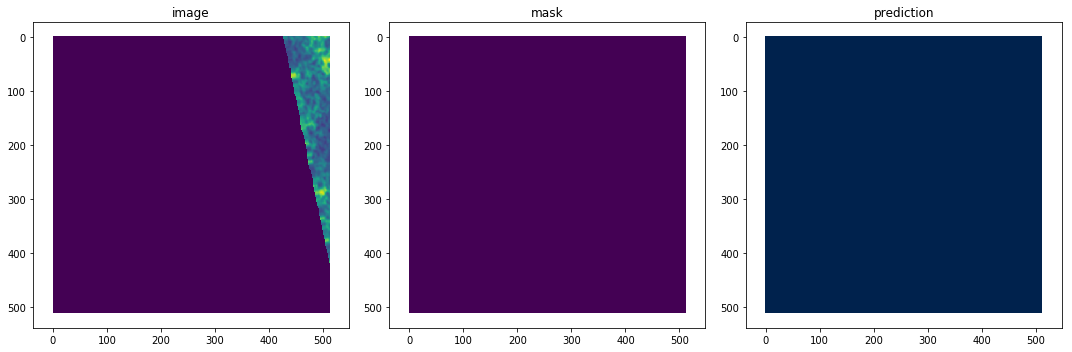

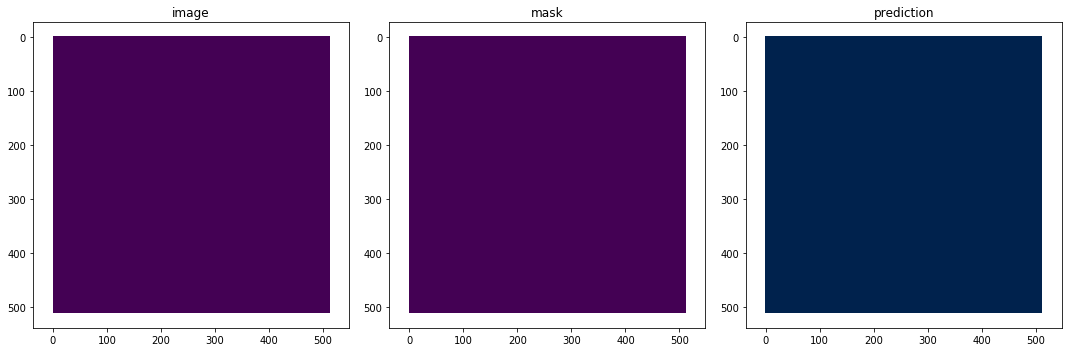

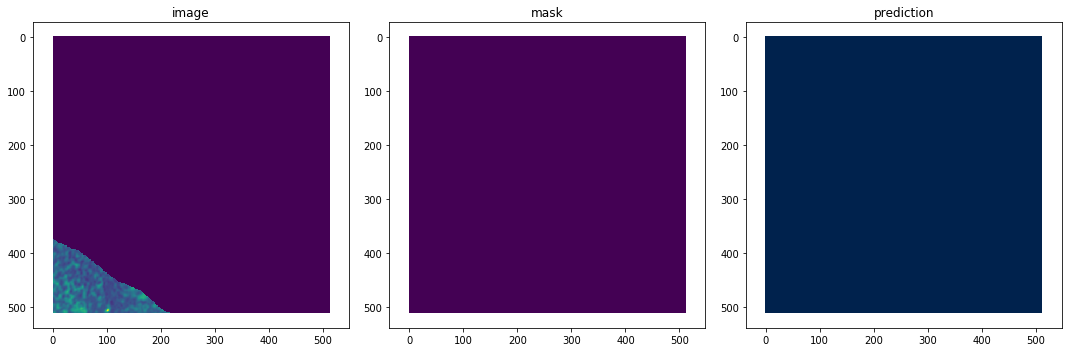

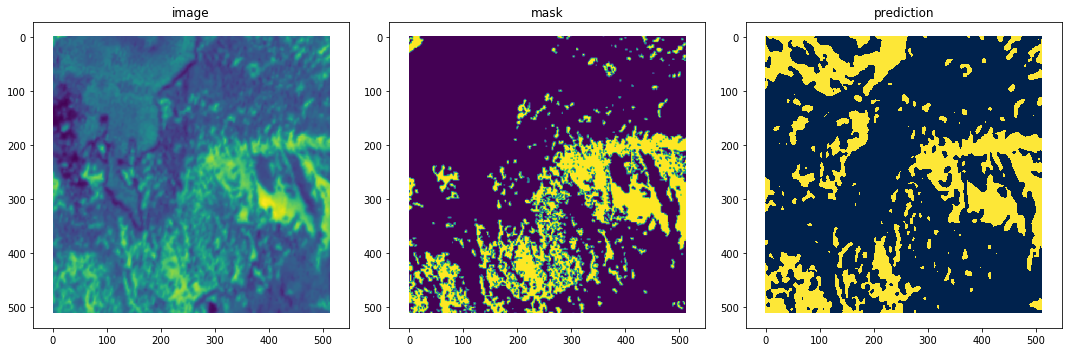

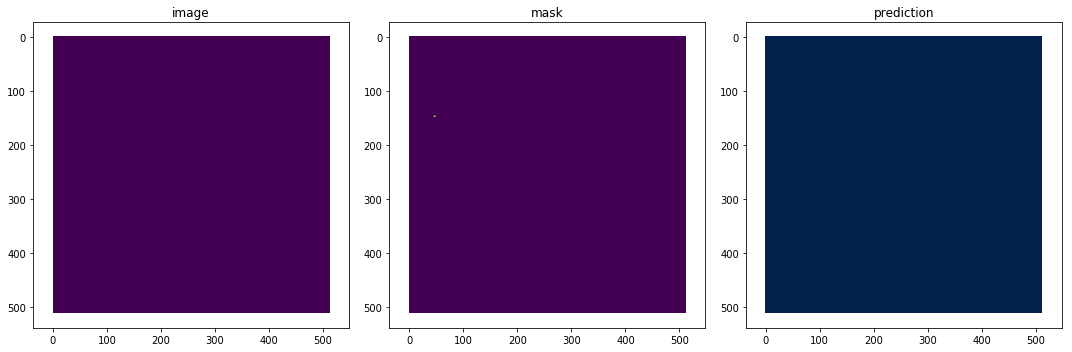

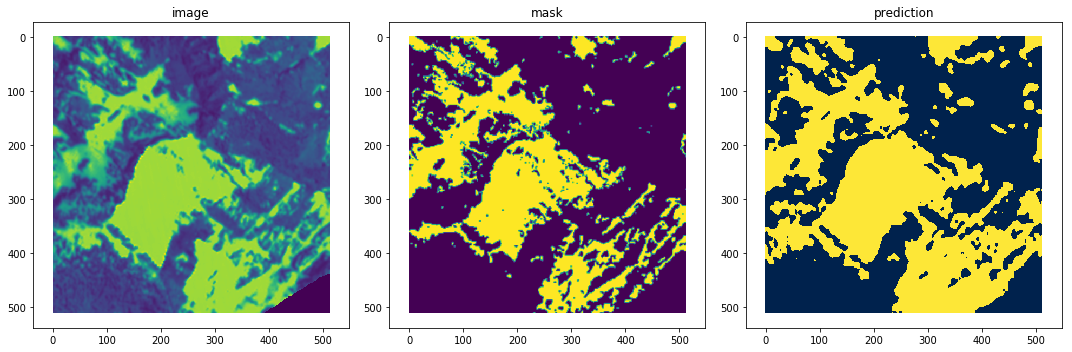

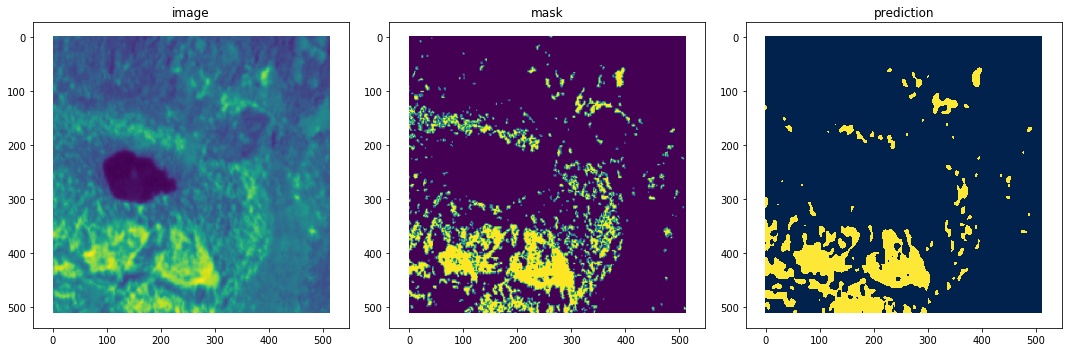

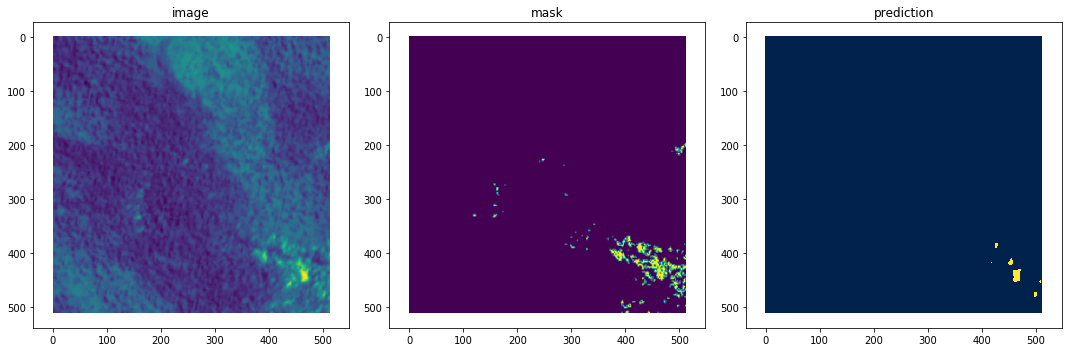

In [185]:
for image in range(preds.shape[0]):
      plot3(s[0][image, 3, :, :], s[1][image, :, :],  (preds[image]).squeeze() > 0.2, tileids[image])
#    plot3(s[0][image, 3, :, :], s[1][image, :, :],  torch.nn.functional.softmax(raw[image].squeeze(), dim=0).data.cpu().numpy())

In [160]:
torch.nn.functional.softmax(raw[7].squeeze(), dim=1).data.cpu().numpy()


array([[0.00134315, 0.00156881, 0.00171217, ..., 0.00169905, 0.00127862,
        0.00099846],
       [0.00105391, 0.00134416, 0.00154028, ..., 0.00164687, 0.0010713 ,
        0.00071931],
       [0.00092586, 0.00121333, 0.00142397, ..., 0.00164342, 0.00105942,
        0.00064938],
       ...,
       [0.00043324, 0.00044736, 0.0004374 , ..., 0.00030467, 0.00023083,
        0.00023869],
       [0.00056556, 0.00059247, 0.00057946, ..., 0.00039719, 0.00030281,
        0.00034915],
       [0.00084346, 0.00077006, 0.00078044, ..., 0.00050578, 0.00042446,
        0.00054962]], dtype=float32)

In [53]:
np.rollaxis(s[0][[3,2,1], 0, :, :].cpu().detach().numpy(), 0, 3)

(512, 512, 3)

In [70]:
 s[1].shape

torch.Size([5, 512, 512])

In [9]:
def map_location(storage, _):
    return storage.cuda() if torch.cuda.is_available() else storage.cpu()

# https://github.com/pytorch/pytorch/issues/7178
    chkpt = torch.load(args.checkpoint, map_location=map_location)
checkpoint = torch.load("/tmp/checkpoint-1")
net.load_state_dict(checkpoint['state_dict'])

In [14]:
raw = net(s[0])


In [ ]:
softmax = 

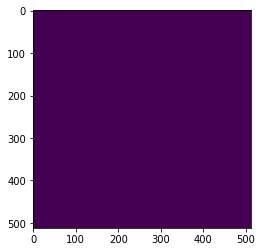

In [28]:
plt.imshow((preds[5].cpu().detach().numpy() > -0.3).squeeze())

In [59]:
plt.imshow((preds[6].cpu().detach().numpy() > -1).squeeze())

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [54]:
preds = torch.nn.functional.softmax(raw, dim=0).data.cpu().numpy()

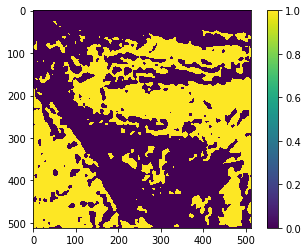

In [62]:
plt.imshow(preds[6].squeeze() > 0.5, vmin = 0, vmax =1 )
plt.colorbar()

## Save Model

In [19]:
time = datetime.now().strftime('%y%m%d-%X')
fname = 'checkpoint-{}'.format(time)

In [20]:
# upload to s3
sess = boto3.Session(profile_name=environ['AWS_DEFAULT_PROFILE'])
fs = s3fs.S3FileSystem(session=sess)
f = s3fs.S3File(fs, 'planet-snowcover-models/' + fname, 'wb', )

In [21]:
torch.save({'state_dict' : net.state_dict(), 'optimizer': optimizer.state_dict()}, f)

In [22]:
f.close()

In [27]:
print(f.key)

checkpoint-190319-20:47:57


---